# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Some Pre-requisites

#### Import libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pickle
import random
import cv2
import time
import glob

%matplotlib inline

## Step 1: Loading & preparing the data

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [2]:
# Load pickled data
# Pickle is used to serialize the data so that it can be saved to a disk

training_file = './data/train.p'
validation_file = './data/valid.p'
testing_file = './data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)

#Each pickled dataset is a dictionary of 4 keys
#dict_keys(['sizes', 'labels', 'features', 'coords'])
#print(train.keys())

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']

In [3]:
#Initializations

#Check if the Number of labels are same as number of input images
assert(len(X_train) == len(y_train))
n_train = len(X_train)

assert(len(X_valid) == len(y_valid))
n_valid = len(X_valid)

# Image Shape
image_shape = X_train[0].shape
#print(image_shape)

# Number of classes / labels
n_classes = len(np.unique(y_train))

#### Lable Names 

In [4]:
def readcsv(file):
    with open(file) as csvfile:
        reader = csv.DictReader(csvfile)
        label_dict = {row['ClassId']:row['SignName'] for row in reader}
        return label_dict

count, label = np.unique(y_train, return_counts=True)
label_dict = readcsv('signnames.csv')

def get_label_name(label_no):
    return label_dict[label_no]

#### Image Pre-processing
As part of this step, each image is processed in the following sequence
- Images in Training set are in order, so to get better results and prevent overfitting, shuffle the dataset. Shuffling should be done for both Images & labels in sync.
- Gray Scale Conversion : Modifying the images to Gray scale will reduce the computational requirements
- CLAHE : This is called Adaptive Histogram Equalization which enhances the contrast of an image which helps for easy detection
- Normalize : Image normalization makes sure the data is zero-centered so that the gradient descent works effectively
After the pre-processing, the images are assinged back to the same variables

In [5]:
def grayscale(img_set):
    gray_img_set = []
    for img in img_set:
            gray_img_set.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return gray_img_set


#Perform histogram equalization using CLAHE algorithm on grayscale images
def clahe_equalize(img_set):
    clahe_img_set = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    for img in img_set:
        clahe_img = np.expand_dims(clahe.apply(img), axis = 2)
        clahe_img_set.append(clahe_img)
    return clahe_img_set

def normalize(img_set):
    norm_img_set = []
    for img in img_set:
        norm_img_set.append((img - 127.5)/127.5)
    return norm_img_set

In [6]:
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)
X_train_gry = grayscale(X_train_shuffle)
X_train_clahe = clahe_equalize(X_train_gry)
X_train_shuffle_normalized = normalize(X_train_clahe)
X_train, y_train = X_train_shuffle_normalized, y_train_shuffle

X_valid_shuffle, y_valid_shuffle = shuffle(X_valid, y_valid)
X_valid_gry = grayscale(X_valid_shuffle)
X_valid_clahe = clahe_equalize(X_valid_gry)
X_valid_shuffle_normalized = normalize(X_valid_clahe)
X_valid, y_valid = X_valid_shuffle_normalized, y_valid_shuffle

In [7]:
#This snippet reads the label names from the csv file. Labels in the data set are numbers, and this file has the corresponding names
label, count = np.unique(y_train_shuffle, return_counts=True)
#print('count',count)
label_dict_shuffle = readcsv('signnames.csv')
#print('\nLabels vs Count to ensure this pair doesn\'t change post shuffling\n')
count_var = []
for i, j in zip(count, label):
    #print('{} :: {}'.format(label_dict_shuffle[repr(j)], i))
    count_var.append(i)

#### Histogram representation of the training set

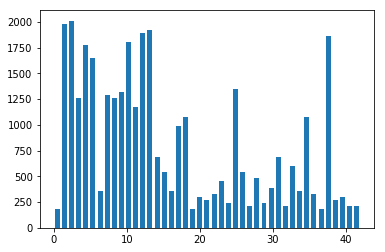

In [8]:
#Histogram display for original training set
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) /2
plt.bar(center, hist, align='center', width=width)
plt.show()

#### Data Augmentation
It is clear from the above histogram representation that some of the image classes has very small training set, and for the model to work effectively, data augmentation is done by duplicating the data set to have more number of images for each class

In this snippet, we ensure each class has atleast 800 Images in t

In [9]:
print('Before Augmentation', len(X_train))

#Data Augmentation
#print('X, y shapes:', X_train.shape, y_train.shape)

input_indices = []
output_indices = []

for class_n in range(n_classes):
    print(class_n, ': ', end='')
    class_indices = np.where(y_train == class_n) #This returns a tuple 0:array([  127,   259,   330 ...], dtype=int64), hence later we get only [0] element from this tuple
    n_samples = len(class_indices[0])
    if n_samples < 800:
        for i in range(800 - n_samples):
            input_indices.append(class_indices[0][i%n_samples])
            output_indices.append(len(X_train))
            new_img = X_train[class_indices[0][i % n_samples]]
            #new_img = random_translate(random_scaling(random_warp(random_brightness(new_img))))
            X_train = np.concatenate((X_train, [new_img]), axis=0)
            y_train = np.concatenate((y_train, [class_n]), axis=0)
            if i % 50 == 0:
                print('|', end='')
            elif i % 10 == 0:
                print('-',end='')
    print('')
            
print('After Augmentation', len(X_train))

Before Augmentation 34799
0 : |----|----|----|----|----|----|----|----|----|----|----|----|-
1 : 
2 : 
3 : 
4 : 
5 : 
6 : |----|----|----|----|----|----|----|----|---
7 : 
8 : 
9 : 
10 : 
11 : 
12 : 
13 : 
14 : |----|----|
15 : |----|----|----|----|----|
16 : |----|----|----|----|----|----|----|----|---
17 : 
18 : 
19 : |----|----|----|----|----|----|----|----|----|----|----|----|-
20 : |----|----|----|----|----|----|----|----|----|----
21 : |----|----|----|----|----|----|----|----|----|----|--
22 : |----|----|----|----|----|----|----|----|----|-
23 : |----|----|----|----|----|----|----
24 : |----|----|----|----|----|----|----|----|----|----|----|
25 : 
26 : |----|----|----|----|----|
27 : |----|----|----|----|----|----|----|----|----|----|----|---
28 : |----|----|----|----|----|----|-
29 : |----|----|----|----|----|----|----|----|----|----|----|
30 : |----|----|----|----|----|----|----|----|
31 : |----|----|
32 : |----|----|----|----|----|----|----|----|----|----|----|---
33 : |----|-

#### Histogram representation of the training data set - After Augmentation

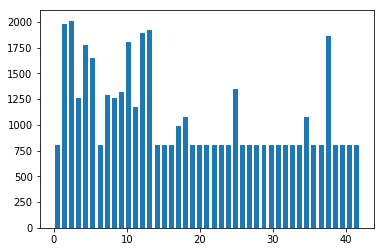

In [10]:
#Histogram display
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) /2
plt.bar(center, hist, align='center', width=width)
plt.show()

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Neural Network Model
This is based on LeNet Architecture by Yann LeCunn

#### Constants for the training model

In [9]:
LEARN_RATE = 0.0005
BATCH_SIZE = 128
EPOCHS = 20
KEEP_PROB = 0.5

In [10]:
# Conv --> MaxPool --> Conv --> MaxPool --> FC1 --> FC2 --> o/p
def NN_LeNet(inputs):
    """
    LeNet Architecture
    CN1 --> P1 --> CN2 --> P2 --> Flatten --> FC1 --> FC2 --> O/P
    Each step after CN & FC follows by an activation layer
    Here are the dimensions of LeNet

    Input : 32, 32, 1 #Gray scale has 1 channel. If you are using color images, this has to be 3
    Layer1 : CN1 Output : 30, 30, 6
    Layer2 : P1 Output  : 15, 15, 6
    Layer3 : CN2 Output : 12, 12, 32
    Layer4 : P2 Output  : 6, 6, 32
    Layer5 : CN3 Output : 4, 4, 32
    Flatten
    Layer6 : FC1 Output : 512
    Layer7 : FC2 Output : 256
    Layer8 : FC8 Output : 120
    Layer9 : Logits     : 43 #43 different classes in German Traffic Sign dataset
    """

    #Defining weights, bias and outputs for each Layer
    mu = 0 #Mean of the variables in the random distribution
    sigma = 0.1 #Variance is 0.1
    
    #Layer1 - Convolution - Output Size : 30, 30, 6
    #After conversion to Gray scale, the dimension size is 1 instead of 3 (RGB)
    w_layer1 = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 6), mean=mu, stddev=sigma))
    b_layer1 = tf.Variable(tf.zeros(6))
    conv_layer1 = tf.nn.conv2d(inputs, w_layer1, strides=[1,1,1,1], padding='VALID') + b_layer1
    act_layer1 = tf.nn.relu(conv_layer1)
    #drop_layer1 = tf.nn.dropout(act_layer1, KEEP_PROB)

    #Layer2 - Max Pooling - Output Size : 15, 15, 6
    pool_layer2 = tf.nn.max_pool(act_layer1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer3 - Convolution - Output Size : 12, 12, 32 ==> 16 filters, size is (W + 2P - F)/S + 1
    #Filters changed to 32 - deviating from LeNet architecture
    w_layer3 = tf.Variable(tf.truncated_normal(shape=(4, 4, 6, 32), mean=mu, stddev=sigma))
    b_layer3 = tf.Variable(tf.zeros(32))
    conv_layer3 = tf.nn.conv2d(pool_layer2, w_layer3, strides=[1, 1, 1, 1], padding='VALID') + b_layer3
    act_layer3 = tf.nn.relu(conv_layer3)
    #drop_layer3 = tf.nn.dropout(act_layer3, KEEP_PROB)

    #Layer4 - Max Pooling - Output Size : 6, 6, 32
    pool_layer4 = tf.nn.max_pool(act_layer3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer5- Convolution - Output Size : 4, 4, 32 ==> 16 filters, size is (W + 2P - F)/S + 1
    #Filters changed to 32 - deviating from LeNet architecture
    w_layer5= tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean=mu, stddev=sigma))
    b_layer5= tf.Variable(tf.zeros(32))
    conv_layer5= tf.nn.conv2d(pool_layer4, w_layer5, strides=[1, 1, 1, 1], padding='VALID') + b_layer5
    act_layer5 = tf.nn.relu(conv_layer5)
    #drop_layer3 = tf.nn.dropout(act_layer3, KEEP_PROB)

    
    #Flatenning as next layers are fully connected
    flatten_vect = tf.contrib.layers.flatten(act_layer5)

    #Layer5 - Fully Connected - Output = 120. Input dimension would be 4*4*32 = 512
    w_layer6= tf.Variable(tf.random_normal(shape=(512, 256), mean=mu, stddev=sigma))
    b_layer6 = tf.Variable(tf.zeros(256))
    fc_layer6 = tf.matmul(flatten_vect, w_layer6) + b_layer6
    act_layer6 = tf.nn.relu(fc_layer6)
    drop_layer6 = tf.nn.dropout(act_layer6, KEEP_PROB)

    #Layer6 - Fully Connected - Output = 84. Input dimension is 120
    w_layer7 = tf.Variable(tf.random_normal(shape=(256, 120), mean=mu, stddev=sigma))
    b_layer7 = tf.Variable(tf.zeros(120))
    fc_layer7 = tf.matmul(drop_layer6, w_layer7) + b_layer7
    act_layer7 = tf.nn.relu(fc_layer7)
    drop_layer7 = tf.nn.dropout(act_layer7, KEEP_PROB)

    #Layer6 - Fully Connected - Output = 84. Input dimension is 120
    w_layer8 = tf.Variable(tf.random_normal(shape=(120, 84), mean=mu, stddev=sigma))
    b_layer8 = tf.Variable(tf.zeros(84))
    fc_layer8 = tf.matmul(drop_layer7, w_layer8) + b_layer8
    act_layer8 = tf.nn.relu(fc_layer8)
    drop_layer8 = tf.nn.dropout(act_layer8, KEEP_PROB)

    #Layer7 - Logits - Output Size : 43 types of image classes in the input dataset
    w_layer9 = tf.Variable(tf.random_normal(shape=(84, 43), mean=mu, stddev=sigma))
    b_layer9 = tf.Variable(tf.zeros(43))
    logits = tf.matmul(drop_layer8, w_layer9) + b_layer9
    
    return logits

### Defining Input Variables
This is for storing the individual batch features & labels
The inputs will be fed at runtime from the batches made out of training data set

Batchsize is None so that it can accept a batch of anysize later at runtime

In [11]:
#None is a placeholder which depends on the number of input images in the batch (k)
#Observe that input data will be float, but labels will always be integers. Otherwise one hot doesn't work
input_data = tf.placeholder(tf.float32, (None, 32, 32, 1))
input_labels = tf.placeholder(tf.int32, (None))
one_hot_labels = tf.one_hot(input_labels, 43)

### Training Pipeline
In this pipeline, we train the model by calculating the following
Logits are calculated using the Neural Network
Cross Entropy loss is the difference between the logits vector and ground truth(in the form of one hot encoded vector)
Average over cross entropy of all the training images (of this batch)
Minimize the loss using Adam Optimizer
Using the loss determined, backprop and adjust weights

THis results in a pipeline that can be used for training. But data has to be fed to this pipeline so that the NN can be trained

In [12]:
logits = NN_LeNet(input_data)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_labels)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARN_RATE)
training_operation = optimizer.minimize(loss)

### Evaluating the Model
In this cell, we evaluate the model by comparing the output of the model to the ground truth
Correct Prediction is determined by comparing the logits output to the ground truth variables(in one-hot format)
Then Accuracy of your model is measured by calculating the model's overall accuracy by calculating the individual accuracies
Evaluate function takes complete input data, splits into batches to calculate the accuracy and finally combines it

In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(x_data, y_data):
    total_accuracy = 0
    length_inputs = len(x_data)
    sess = tf.get_default_session()
    for offset in range(0, length_inputs, BATCH_SIZE):
        batch_x, batch_y = x_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        batch_accuracy = sess.run(accuracy, feed_dict={input_data:batch_x, input_labels:batch_y})
        total_accuracy += (batch_accuracy * len(batch_x))
    return total_accuracy / length_inputs

### Train the Model
In this cell, we train the model
Shuffle the inputs so that your model is not dependent on the order of the inputs
Use the training_operation which is defined in the 'Training Pipeline' to do a fwd/back pass and update the weights and biases


A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

- Note : It is observed that having dropout layers only on fully connected layers yeilds more accuracy than to have the dropouts on COnvolution layers. The differece is about 1% as observed in about 10 different training cycles

Training...
EPOCH 1    Training Accuracy = 0.361 Validation Accuracy = 0.332
EPOCH 2    Training Accuracy = 0.566 Validation Accuracy = 0.530
EPOCH 3    Training Accuracy = 0.689 Validation Accuracy = 0.663
EPOCH 4    Training Accuracy = 0.754 Validation Accuracy = 0.715
EPOCH 5    Training Accuracy = 0.800 Validation Accuracy = 0.755
EPOCH 6    Training Accuracy = 0.824 Validation Accuracy = 0.794
EPOCH 7    Training Accuracy = 0.847 Validation Accuracy = 0.808
EPOCH 8    Training Accuracy = 0.865 Validation Accuracy = 0.825
EPOCH 9    Training Accuracy = 0.877 Validation Accuracy = 0.839
EPOCH 10    Training Accuracy = 0.886 Validation Accuracy = 0.843
EPOCH 11    Training Accuracy = 0.898 Validation Accuracy = 0.856
EPOCH 12    Training Accuracy = 0.905 Validation Accuracy = 0.862
EPOCH 13    Training Accuracy = 0.911 Validation Accuracy = 0.861
EPOCH 14    Training Accuracy = 0.915 Validation Accuracy = 0.878
EPOCH 15    Training Accuracy = 0.928 Validation Accuracy = 0.885
EPOCH 1

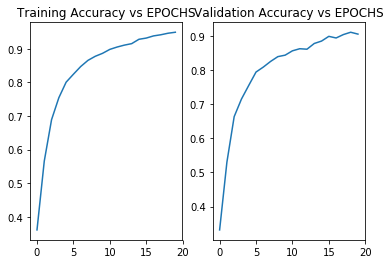

In [14]:
model_file = './temp_traffic_sign_model_arch2'

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_total = len(X_train)
    validation_accuracy_plot = []
    train_accuracy_plot = []
    print('Training...')
    start_time = time.time()
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_total, BATCH_SIZE):
            batch_x, batch_y = X_train[offset:offset+BATCH_SIZE], y_train[offset:offset+BATCH_SIZE]
            sess.run(training_operation, feed_dict={input_data:batch_x, input_labels:batch_y})
        
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print('EPOCH {}    Training Accuracy = {:.3f} Validation Accuracy = {:.3f}'.format(i+1, training_accuracy, validation_accuracy))
        
        train_accuracy_plot.append(training_accuracy)
        validation_accuracy_plot.append(validation_accuracy)
        
    plt.figure(3)
    plt.subplot(121)
    plt.plot(train_accuracy_plot)
    plt.title('Training Accuracy vs EPOCHS')
    plt.subplot(122)
    plt.plot(validation_accuracy_plot)
    plt.title('Validation Accuracy vs EPOCHS')
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, model_file)
    
    print('Total time for training {:.3f}'.format(time.time() - start_time))
    print('Model Saved to', model_file)
    

#### Evaluating the model with Test set

In [16]:
testing_file = './data/test.p'

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

#Each pickled dataset is a dictionary of 4 keys
#dict_keys(['sizes', 'labels', 'features', 'coords'])
#print(test.keys())
X_test, y_test = test['features'], test['labels']
print('Length of Test Set {}'.format(len(X_test)))
#Same pre-processing as the training set
X_test_shuffle, y_test_shuffle = shuffle(X_test, y_test)
X_test_gry = grayscale(X_test_shuffle)
X_test_clahe = clahe_equalize(X_test_gry)
X_test_shuffle_normalized = normalize(X_test_clahe)
X_test, y_test = X_test_shuffle_normalized, y_test_shuffle

Length of Test Set 12630


In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./temp_traffic_sign_model_arch2.meta')
    saver2.restore(sess, './temp_traffic_sign_model_arch2') 
    test_accuracy = evaluate(X_test, y_test)
    print('Test Set Accuracy = {:.3f}'.format(test_accuracy))

Test Set Accuracy = 0.895


#### Accuracy on the test set - which was never seen by the model is 93.9%

---

## Step 3: Test a Model on New Images

- 6 random images are downloaded from internet in 32x32 color images. Hence this is of the same dimensions as our training set
- Ground truth for these labels are defined by looking at the images and assigning them values by looking at the `signatures.csv`

### Load and Output the Images

(32, 32, 3)


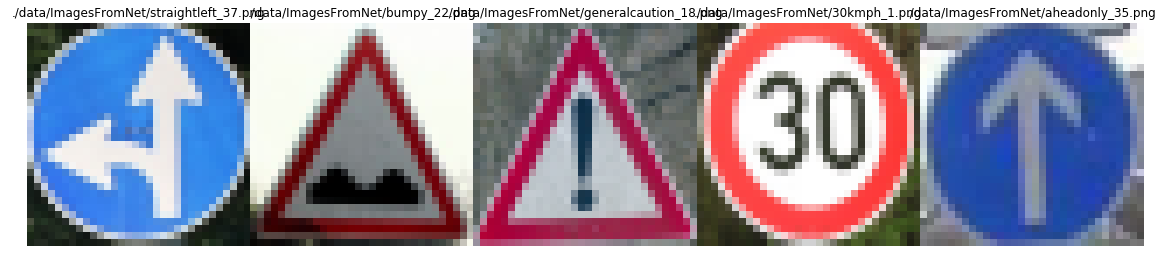

In [77]:
fig, axs = plt.subplots(1,5, figsize=(20, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
#axs = axs.ravel()

my_images = []

for i, img in enumerate(glob.glob('./data/ImagesFromNet/*.png')):
    image = cv2.imread(img)
    my_images.append(image)
    plt.subplot(1,5,i+1)
    plt.title(img)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
my_images_gry = grayscale(my_images)
my_images_clahe = clahe_equalize(my_images_gry)
my_images_norm = normalize(my_images_clahe)
#my_images = np.asarray(my_images_norm)

### Predict the Sign Type for Each Image

In [50]:
my_labels = [37,22,18,1,35]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver3 = tf.train.import_meta_graph('./temp_traffic_sign_model_arch2.meta')
    saver3.restore(sess, './temp_traffic_sign_model_arch2') 
    my_accuracy = evaluate(my_images, my_labels )
    print("Test Set Accuracy for images from internet = {:.3f}".format(my_accuracy))

Test Set Accuracy for images from internet = 0.800


### Voila!!!
#### The prediction on the images downloaded from internet is 100%
Though this may not represent the test accuracy of the model with respect to the test set in the 'German Traffic Sign Classifier' or any image for that matter in internet with different exposures, the model has done well with the sample test set.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

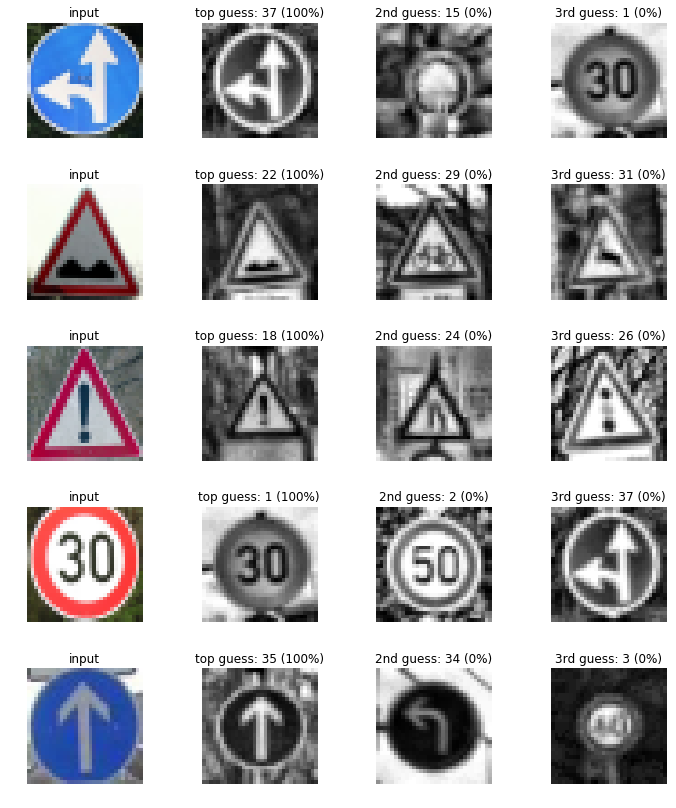

In [117]:
softmax_prob = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_prob, k=3)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver4 = tf.train.import_meta_graph('./traffic_sign_model_arch2.meta')
    saver4.restore(sess, './traffic_sign_model_arch2')
    my_softmax = sess.run(softmax_prob, feed_dict={input_data:my_images_norm})
    my_top_k = sess.run(top_k, feed_dict={input_data:my_images_norm})
    fig, axs = plt.subplots(len(my_images),4, figsize=(12, 14))
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()
    
    for i, image in enumerate(my_images):
        axs[4*i].axis('off')
        axs[4*i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[4*i].set_title('input')
        
        guess1 = my_top_k[1][i][0]
        index1 = np.argwhere(y_train == guess1)[0]
        #print('{} --> {}'.format(guess1, index1))
        axs[4*i+1].axis('off')
        axs[4*i+1].imshow(X_train[index1[0]].squeeze(), cmap='gray')
        axs[4*i+1].set_title('top guess: {} ({:.0f}%)'.format(guess1, 100*my_top_k[0][i][0]))
        
        guess2 = my_top_k[1][i][1]
        index2 = np.argwhere(y_train == guess2)[0]
        #print('{} --> {}'.format(guess2, index2))
        axs[4*i+2].axis('off')
        axs[4*i+2].imshow(X_train[index2[0]].squeeze(), cmap='gray')
        axs[4*i+2].set_title('2nd guess: {} ({:.0f}%)'.format(guess2, 100*my_top_k[0][i][1]))
        
        guess3 = my_top_k[1][i][2]
        index3 = np.argwhere(y_train == guess3)[0]
        #print('{} --> {}'.format(guess3, index3))
        axs[4*i+3].axis('off')
        axs[4*i+3].imshow(X_train[index3[0]].squeeze(), cmap='gray')
        axs[4*i+3].set_title('3rd guess: {} ({:.0f}%)'.format(guess3, 100*my_top_k[0][i][2]))       
        

### Top 5 Softmax Probabilities of each image in test set

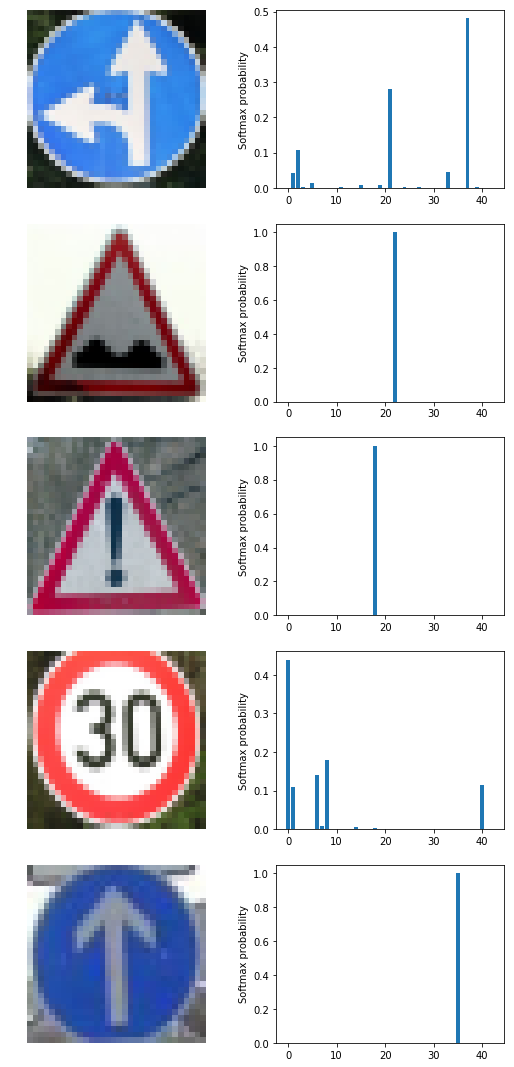

In [120]:
fig, axs = plt.subplots(5,2, figsize=(9, 19))
axs = axs.ravel()

for i in range(len(my_softmax)*2):
    if i%2 == 0:
        axs[i].axis('off')
        axs[i].imshow(cv2.cvtColor(my_images[i//2], cv2.COLOR_BGR2RGB))
    else:
        axs[i].bar(np.arange(n_classes), my_softmax[(i-1)//2]) 
        axs[i].set_ylabel('Softmax probability')

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.